In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\eurib\AppData\Local\Temp\ipykernel_15132\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Get the column headers of the "Measurement" table
columns = Measurement.__table__.columns.keys()

# Print the column headers
print("Column Headers:")
for column in columns:
    print(column)

Column Headers:
id
station
date
prcp
tobs


In [10]:
# Get the column headers of the "Measurement" table
columns = Station.__table__.columns.keys()

# Print the column headers
print("Column Headers:")
for column in columns:
    print(column)

Column Headers:
id
station
name
latitude
longitude
elevation


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f'The most recent date in the dataset is: {most_recent_date}')

The most recent date in the dataset is: 2017-08-23


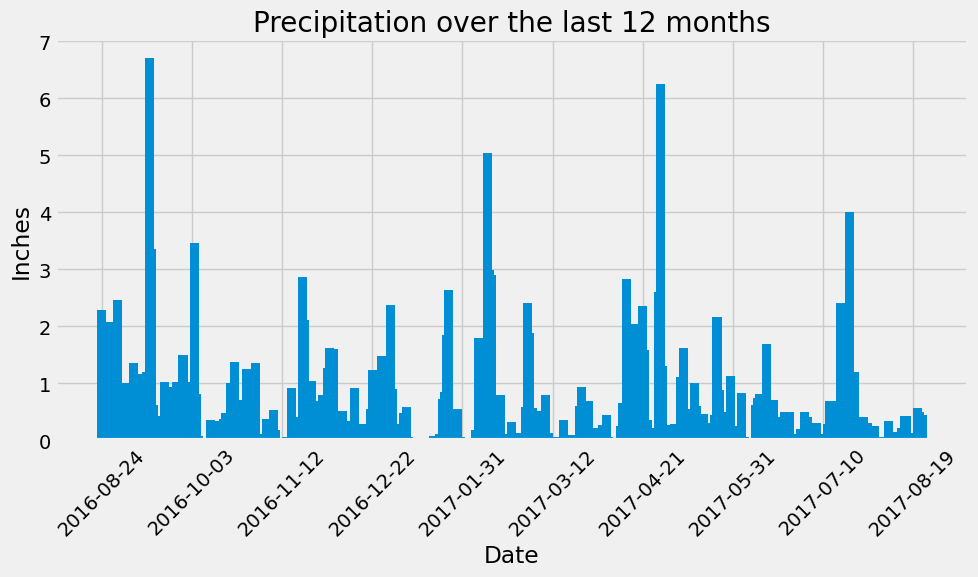

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_12months = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')- dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12months).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.bar(precipitation_df["Date"], precipitation_df["Precipitation"], width=4)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation over the last 12 months")
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df[["Precipitation"]].describe()
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
number_of_stations = session.query(Station).distinct().count()
print(f'The total number of stations is: {number_of_stations}')

The total number of stations is: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations")
for station, count in active_stations:
    print(f'Station; {station}, Count: {count}')



Most Active Stations
Station; USC00519281, Count: 2772
Station; USC00519397, Count: 2724
Station; USC00513117, Count: 2709
Station; USC00519523, Count: 2669
Station; USC00516128, Count: 2612
Station; USC00514830, Count: 2202
Station; USC00511918, Count: 1979
Station; USC00517948, Count: 1372
Station; USC00518838, Count: 511


In [16]:
# Get the most active station and its corresponding ID
most_active_station = active_stations[0][0]
most_active_station_id = session.query(Station.id).filter(Station.station == most_active_station).first()[0]
print(f'Most active station: {most_active_station}')
print(f"Most active station's ID: {most_active_station_id}")

Most active station: USC00519281
Most active station's ID: 7


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
temperature_stats= session.query(func.min(Measurement.tobs), 
                                 func.max(Measurement.tobs), 
                                 func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).first()

lowest_temp = temperature_stats[0]
highest_temp = temperature_stats[1]
avg_temp = temperature_stats[2]

print(f'Temperature statistics for the most active station {most_active_station}')
print(f'Lowest temp: {lowest_temp}')
print(f'Highest temp; {highest_temp}')
print(f'Average temp: {avg_temp}')

                                

Temperature statistics for the most active station USC00519281
Lowest temp: 54.0
Highest temp; 85.0
Average temp: 71.66378066378067


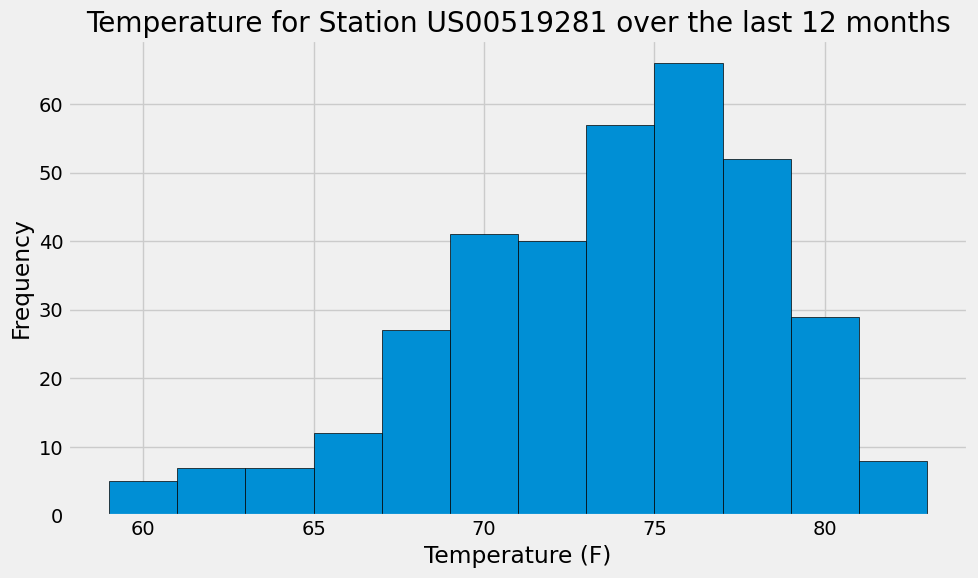

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = 'USC00519281'

last_year = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')- dt.timedelta(days = 365)

temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()


temperature_data_df =pd.DataFrame(temperature_data, columns=['Date','Temperature'])


plt.figure(figsize=(10,6))
plt.hist(temperature_data_df['Temperature'], bins=12, edgecolor='black')
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature for Station US00519281 over the last 12 months")
plt.tight_layout()

plt.show()

# Close Session

In [19]:
# Close Session
session.close()